# Reimplementing the CelebA experiment

In this notebook, I'm trying to reimplement the CelebA experiment results from the awesome [InfoGAN paper](https://arxiv.org/pdf/1606.03657v1.pdf) (Chen et al.).

My relevant additions to this repository (which contains the code published by the authors) are adding the "celebA" model to [infogan/models/regularized_gan.py](infogan/models/regularized_gan.py) and some small adjustments to [infogan/algos/infogan_trainer.py](infogan/algos/infogan_trainer.py) to allow for generating samples after training.

In [1]:
from __future__ import print_function
from __future__ import absolute_import
from infogan.misc.distributions import Uniform, Categorical, Gaussian, MeanBernoulli

import tensorflow as tf
from infogan.misc.celebA_dataset import CelebADataset
from infogan.models.regularized_gan import RegularizedGAN
from infogan.algos.infogan_trainer import InfoGANTrainer
from infogan.misc.utils import mkdir_p
import dateutil
import dateutil.tz
import datetime
import os

import numpy as np

In [2]:
#%matplotlib inline

In [3]:
root_log_dir = "logs/celebA"
root_checkpoint_dir = "ckt/celebA"
batch_size = 128
updates_per_epoch = 100    # How often to run the logging.
checkpoint_snapshot_interval = 1000  # Save a snapshot of the model every __ updates.
max_epoch = 50

In [ ]:
# The "C.3 CelebA" input settings:
# "For this task, we use 10 ten-dimensional categorical code and 128 noise variables, resulting in a concatenated dimension of 228.."
c3_celebA_latent_spec = [
    (Uniform(128), False),  # Noise
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
    (Categorical(10), True),
]
c3_celebA_image_size = 32

In [5]:
dataset = CelebADataset()  # The full dataset is enormous (202,599 frames).

print("Loaded {} images into Dataset.".format(len(dataset.raw_images)))
print("Split {} images into training set.".format(len(dataset.train.images)))
print("Image shape: ",dataset.image_shape)

Loaded 202599 images into Dataset.
Split 121559 images into training set.
Image shape:  (32, 32, 3)


In [6]:
model = RegularizedGAN(
    output_dist=MeanBernoulli(dataset.image_dim),
    latent_spec=c3_celebA_latent_spec,  # Trying with the above celebA latent_spec.
    batch_size=batch_size,
    image_shape=dataset.image_shape,
    # Trying with my new celebA network!
    network_type="celebA",
)

In [7]:
now = datetime.datetime.now(dateutil.tz.tzlocal())
timestamp = now.strftime('%Y_%m_%d_%H_%M_%S')
exp_name = "celebA_model_celebA_codes_color_img-align-celeba_10_%s" % timestamp

log_dir = os.path.join(root_log_dir, exp_name)
checkpoint_dir = os.path.join(root_checkpoint_dir, exp_name)

mkdir_p(log_dir)
mkdir_p(checkpoint_dir)

algo = InfoGANTrainer(
    model=model,
    dataset=dataset,
    batch_size=batch_size,
    exp_name=exp_name,
    log_dir=log_dir,
    checkpoint_dir=checkpoint_dir,
    max_epoch=max_epoch,
    updates_per_epoch=updates_per_epoch,
    snapshot_interval=checkpoint_snapshot_interval,
    info_reg_coeff=1.0,
    generator_learning_rate=1e-3,  # original paper's learning rate was 1e-3
    discriminator_learning_rate=2e-4,  # original paper's learning rate was 2e-4
)

In [8]:
#algo.visualize_all_factors()  # ... what does this do?

In [9]:
sess = tf.Session()

algo.train(sess=sess)

Epoch 0 | discriminator_loss: 0.148449; generator_loss: 3.03982; MI_disc: 1.62147; CrossEnt_disc: 21.4044; MI: 1.62147; CrossEnt: 21.4044; max_real_d: 0.996225; min_real_d: 0.488915; max_fake_d: 0.0769569; min_fake_d: 0.0456027


Epoch 1 | discriminator_loss: 0.0453683; generator_loss: 4.00863; MI_disc: 3.95595; CrossEnt_disc: 19.0699; MI: 3.95595; CrossEnt: 19.0699; max_real_d: 0.999911; min_real_d: 0.693943; max_fake_d: 0.0227667; min_fake_d: 0.0175342


Epoch 2 | discriminator_loss: 0.0092645; generator_loss: 5.60071; MI_disc: 6.42161; CrossEnt_disc: 16.6042; MI: 6.42161; CrossEnt: 16.6042; max_real_d: 0.999988; min_real_d: 0.914133; max_fake_d: 0.0042838; min_fake_d: 0.00365663


KeyboardInterrupt: 

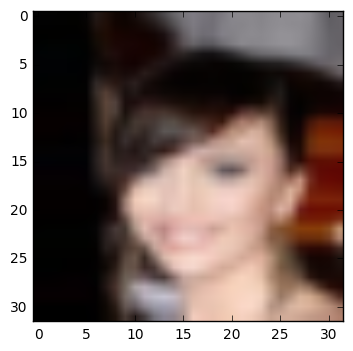

In [16]:
def play_frames_clip(frames):
    ''' frames -- a list/array of np.array images. Plays all frames in the notebook as a clip.'''
    from matplotlib import pyplot as plt
    from IPython import display

    for frame in frames:
        plt.imshow(frame)
        display.display(plt.gcf())
        display.clear_output(wait=True)

print("Displaying some training Images...")
play_frames_clip([frame.reshape(dataset.image_shape) for frame in dataset.train.images[10:20]])

## Using the Trained Model: Generating Images

Alright! Now we've trained the model on our data, and we can use it to generate some new images!

We can just reuse the tiny piece of the TensorFlow graph that generates fake samples, $x$, from the learned distribution. We'll reuse the same `sess` variable that we used for training, so that all the variables still hold their learned values!

In [43]:
generated_images = sess.run(algo.fake_x)
generated_images.shape

(128, 3072)

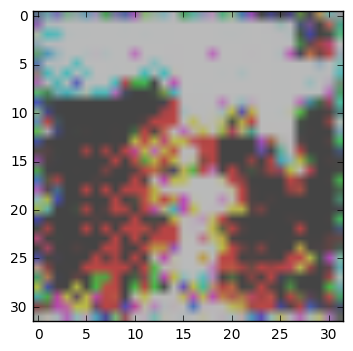

In [61]:
print("Displaying a batch of GENERATED Images...")
play_frames_clip([frame.reshape(dataset.image_shape) for frame in generated_images])